# Solve for temperature and $\tau$ using the direct color-temperature approach
Using what I learned in the last notebook (test_colorcolor), solve for $T$ and $\tau$ in RCW 49 based on the 70 and 160 micron PACS intensities.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline

from astropy.io import fits
from astropy import units as u
from astropy.modeling import models
from astropy.nddata.utils import Cutout2D

In [2]:
# PACS 70 and 160 micron; transform to wavelengths
pacs_freqs = ([70, 160] * u.micron).to(u.Hz, equivalencies=u.spectral())
# Create an array of temperatures
model_T_arr = np.arange(1, 200, 0.1)[:, np.newaxis] * u.K
# Create a model array of blackbodies
model_arr = models.BlackBody(temperature=model_T_arr)

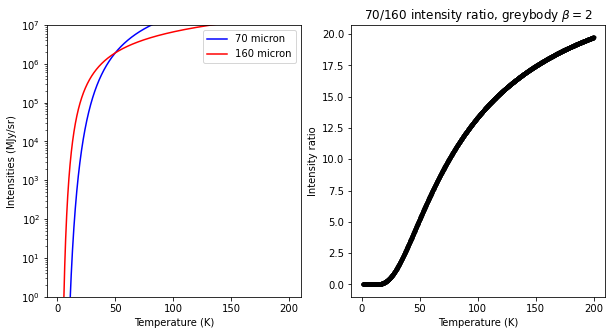

In [25]:
# Evaluate the intensity at both PACS frequencies
model_I_arr = model_arr(pacs_freqs).to(u.MJy/u.sr)
# Calculate intensity ratio
model_br_ratio = model_I_arr[:, 0] / model_I_arr[:, 1]
# Frequency ratio with beta = 2 law
freq_ratio2 = (pacs_freqs[0] / pacs_freqs[1])**2
model_greybody_br_ratio = model_br_ratio * freq_ratio2

%matplotlib inline
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(model_T_arr, model_I_arr[:, 0], color='b', label='70 micron')
plt.plot(model_T_arr, model_I_arr[:, 1], color='r', label='160 micron')
plt.ylabel("Intensities (MJy/sr)")
plt.xlabel("Temperature (K)")
plt.yscale('log'), plt.ylim(1, 1e7)
plt.legend()

plt.subplot(122)
plt.plot(model_T_arr, model_greybody_br_ratio, color='k')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity ratio")
plt.title('70/160 intensity ratio, greybody $\\beta = 2$');

In [4]:
# Use the greybody frequency ratio as the independent variable in a spline fit
model_greybody_br_spline = UnivariateSpline(model_greybody_br_ratio, model_T_arr[:, 0], s=0)

In [5]:
# Load in the RCW 49 Herschel images
pacs_dir = "/home/ramsey/Documents/Research/Feedback/rcw49_data/herschel/processed/1342255009_reproc160"
p70_fn = "PACS70um-image-remapped-conv-plus000080.fits"
p70_fn = os.path.join(pacs_dir, p70_fn)
assert os.path.exists(p70_fn)
p160_fn = "PACS160um-image-remapped-conv-plus000370.fits"
p160_fn = os.path.join(pacs_dir, p160_fn)
assert os.path.exists(p160_fn)

p70_img = fits.getdata(p70_fn)
p160_img = fits.getdata(p160_fn)

# Trim to just the cutout regions (since these are very large maps)
i0, j0 = 2314, 1035
width_i, width_j = 1286, 1286
p70_img = Cutout2D(p70_img, (j0, i0), (width_i, width_j)).data
p160_img = Cutout2D(p160_img, (j0, i0), (width_i, width_j)).data

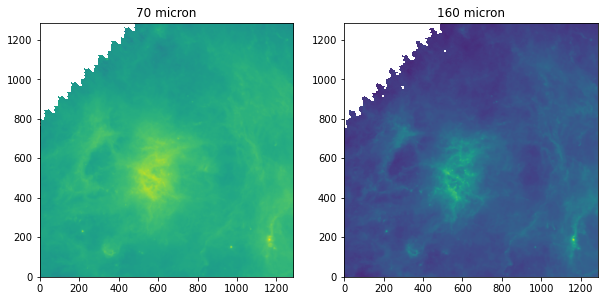

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.arcsinh(p70_img), origin='lower')
plt.title("70 micron")
plt.subplot(122)
plt.imshow(np.arcsinh(p160_img), origin='lower')
plt.title("160 micron");

In [7]:
# Get the ratio of the 70 and 160 micron images
br_img = p70_img / p160_img

# Feed this into the spline for temperature
T_img = model_greybody_br_spline(br_img)

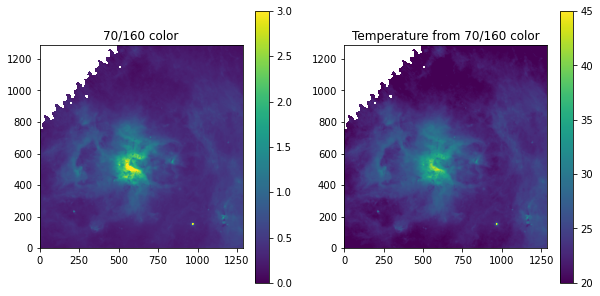

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(br_img, origin='lower', vmin=0, vmax=3)
plt.title("70/160 color")
plt.colorbar()

plt.subplot(122)
plt.imshow(T_img, origin='lower', vmin=20, vmax=45)
plt.title("Temperature from 70/160 color")
plt.colorbar();

# Next, I should re-do this with the PACS bandpasses to see how much of a difference that makes

In [20]:
from mantipython.physics import greybody, dust, instrument

# Set up the PACS detectors for 70 and 160
p70_detector, p160_detector = instrument.get_instrument([70, 160])
# Set up output array
model_bandpass_br_ratio = np.zeros(model_T_arr.size)
# Loop through the temperature array. Need to do everything unitless this time for mantipython
# Since we can't put in tau = 0, put tau = very small (log10(tau) = -8, for example)
args = (-8., dust.TauOpacity(2.))
for i, t in enumerate(model_T_arr.to_value()):
    p70_I = p70_detector.detect(greybody.Greybody(t, *args))
    p160_I = p160_detector.detect(greybody.Greybody(t, *args))
    model_bandpass_br_ratio[i] = p70_I / p160_I

model_bandpass_br_spline = UnivariateSpline(model_bandpass_br_ratio, model_T_arr[:, 0], s=0)

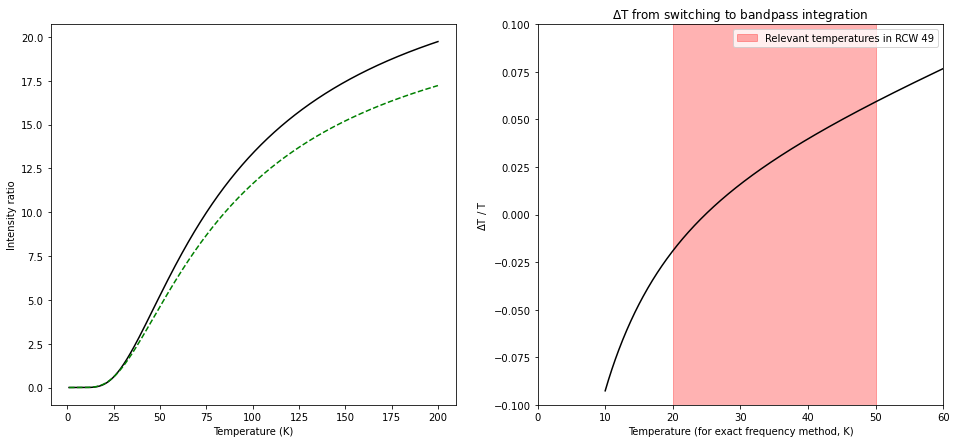

In [56]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
plt.plot(model_T_arr, model_greybody_br_ratio, color='k', label='Exact frequencies')
plt.plot(model_T_arr, model_bandpass_br_ratio, '--', color='g', label='Bandpass integration')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity ratio")

# Make an evenly spaced ratio array that is covered by both of these models
flat_T_arr = model_T_arr.to_value()[:, 0]
tmp_dT = (flat_T_arr - model_greybody_br_spline(model_bandpass_br_ratio))/flat_T_arr
plt.subplot(122)
plt.plot(flat_T_arr[90:], tmp_dT[90:], color='k')
plt.xlim([0, 60]), plt.ylim([-.1, .1])
plt.axvspan(20, 50, alpha=0.3, color='red', label='Relevant temperatures in RCW 49')
plt.title("$\\Delta$T from switching to bandpass integration")
plt.xlabel("Temperature (for exact frequency method, K)")
plt.ylabel("$\\Delta$T / T")
plt.legend();

Looks like the addition of bandpasses will raise the temperature if the original (exact frequency method) temperature was above 25 K or so. The change in temperature remains within 5% between 20 and 50 K, the most relevant temperature range in RCW 49.